# Advanced Model

## Introducción
En esta notebook, desarrollaremos un modelo avanzado de forecasting utilizando técnicas más sofisticadas, como la optimización de hiperparámetros. Compararemos el rendimiento de este modelo con el modelo base para evaluar las mejoras logradas.


## 1. Importación de Librerías

In [1]:
# Procesado de datos
# ==============================================================================
import os
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

# Keras
# ==============================================================================
os.environ["KERAS_BACKEND"] = "tensorflow" # 'tensorflow', 'jax´ or 'torch'
import keras
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

if keras.__version__ > "3.0":
    if keras.backend.backend() == "tensorflow":
        import tensorflow
    elif keras.backend.backend() == "torch":
        import torch
    else:
        print("Backend not recognized. Please use 'tensorflow' or 'torch'.")

# Modelado 
# ==============================================================================
import skforecast
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version Keras: {keras.__version__}")
print(f"{color}Using backend: {keras.backend.backend()}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")
if keras.__version__ > "3.0":
    if keras.backend.backend() == "tensorflow":
        print(f"{color}Version tensorflow: {tensorflow.__version__}")
    elif keras.backend.backend() == "torch":
        print(f"{color}Version torch: {torch.__version__}")
    else:
        print(f"{color}Version torch: {jax.__version__}")

Version skforecast: 0.13.0
Version Keras: 3.4.1
Using backend: tensorflow
Version pandas: 2.2.2
Version numpy: 1.26.4
Version tensorflow: 2.17.0


c:\Users\alam_\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



## 2. Configuración del Entorno

In [10]:
# Configuración de opciones de pandas
pd.set_option('display.max_columns', None)


# Configuración para reproducibilidad
np.random.seed(42)

data_dir = '../data/'
models_dir = '../models/'

## 3. Carga de Datos

In [11]:
# Cargar los datos desde archivos CSV
df = pd.read_parquet(f'{data_dir}base_b_4_att.parquet')

print(df.shape)
df.head()

(59880, 8)


,product_id,city,date,sales,day_of_week,sin_day_of_week,cos_day_of_week,weekend
0,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-01,2.0,5,-0.974928,-0.222521,1
1,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-02,0.0,6,-0.781831,0.623490,1
2,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-03,3.0,0,0.000000,1.000000,0
3,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-04,2.0,1,0.781831,0.623490,0
4,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-05,1.0,2,0.974928,-0.222521,0


## 4. Preparacion de la base

In [12]:
df['series_id']=df['product_id'].astype(str).str.strip() +'_'+df['city'].astype(str).str.strip()
df.head()

,product_id,city,date,sales,day_of_week,sin_day_of_week,cos_day_of_week,weekend,series_id
0,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-01,2.0,5,-0.974928,-0.222521,1,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3
1,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-02,0.0,6,-0.781831,0.623490,1,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3
2,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-03,3.0,0,0.000000,1.000000,0,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3
3,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-04,2.0,1,0.781831,0.623490,0,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3
4,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-05,1.0,2,0.974928,-0.222521,0,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3


In [13]:

## se necesita que los datos tenga esta estructura, esto nos forza a que las fechas anteriores a la venta a la aparecion de un producto tengamos que poner 0, para que todos los productos tengan la misma logitud 

selected_items = df.series_id.unique()
data = df[['series_id','date','sales']]
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = pd.pivot_table(
           data    = data,
           values  = 'sales',
           index   = 'date',
           columns = 'series_id'
       )
data.columns.name = None
data = data.asfreq('1D')
data = data.sort_index()
data.fillna(0,inplace=True)
data.head(4)

C:\Users\alam_\AppData\Local\Temp\ipykernel_35700\3653782510.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,010facf4-08f0-4b25-9eef-2522a8caed4b_B1,015ad371-f82f-4eba-ab3a-dc4c77262d23_B2,015ad371-f82f-4eba-ab3a-dc4c77262d23_B3,016910ce-27cd-4536-9b14-96e9caec3f56_B3,01ceb2f7-f178-4a23-b470-20755a3be241_B3,03506bee-8edc-4c03-b10e-4126b943a339_B1,03506bee-8edc-4c03-b10e-4126b943a339_B3,03b56f4c-f2ec-4ee5-8341-87ef3e39a90e_B3,04587b04-b34d-477a-8c24-1edf1f9effc7_B3,047af93a-b988-4cfe-8af7-5d793960b295_B3,04f07f2c-ed89-4c69-9de3-e24f28032748_B1,04f07f2c-ed89-4c69-9de3-e24f28032748_B2,04f07f2c-ed89-4c69-9de3-e24f28032748_B3,0548991e-185f-497f-9c37-d7e9c51edff0_B1,0548991e-185f-497f-9c37-d7e9c51edff0_B2,0548991e-185f-497f-9c37-d7e9c51edff0_B3,0576299b-d2b9-4a95-9f65-aa74f303726a_B1,0576299b-d2b9-4a95-9f65-aa74f303726a_B2,0576299b-d2b9-4a95-9f65-aa74f303726a_B3,05d77e9c-c279-402d-b882-f2f533e0b221_B1,05d77e9c-c279-402d-b882-f2f533e0b221_B2,05d77e9c-c279-402d-b882-f2f533e0b221_B3,063a0fae-8732-42e9-ae25-aefcdffce44e_B1,063a0fae-8732-42e9-ae25-aefcdffce44e_B2,063a0fae-8732-42e9-ae25-aefcdffce44e_B3,06c3de3a-5134-4a31-8b48-9d7bd0370125_B2,06c3de3a-5134-4a31-8b48-9d7bd0370125_B3,06d507fe-e703-4a06-8efb-bd61a38990f3_B1,06d507fe-e703-4a06-8efb-bd61a38990f3_B3,07078fae-2d0b-4225-99aa-587b5920a2ee_B3,07c415af-fed1-4cc4-b702-7314e1eeba4c_B3,094ecf84-9014-4900-9c53-efc209159c40_B1,094ecf84-9014-4900-9c53-efc209159c40_B2,094ecf84-9014-4900-9c53-efc209159c40_B3,0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B1,0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B2,0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B3,0aa4d643-34b7-4973-85d0-b15efeff3e54_B1,0aa4d643-34b7-4973-85d0-b15efeff3e54_B2,0aa4d643-34b7-4973-85d0-b15efeff3e54_B3,0b0c7b9a-ec28-4971-9d11-435c2db92869_B3,0be705d4-b5df-47b9-9947-4f30ffb916ef_B1,0be705d4-b5df-47b9-9947-4f30ffb916ef_B2,0be705d4-b5df-47b9-9947-4f30ffb916ef_B3,0c511b76-393d-4970-85a0-db86ea2f16fe_B1,0c511b76-393d-4970-85a0-db86ea2f16fe_B3,0c72f97a-24c8-497c-b405-f4f79088b06d_B1,0c72f97a-24c8-497c-b405-f4f79088b06d_B2,0c72f97a-24c8-497c-b405-f4f79088b06d_B3,0cd34cc6-1752-4523-89a6-9852a560c41a_B1,0cd34cc6-1752-4523-89a6-9852a560c41a_B2,0cd34cc6-1752-4523-89a6-9852a560c41a_B3,0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B1,0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B2,0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B3,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B1,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B2,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B3,0d6f6c33-a832-4136-b73b-020d7a2f3550_B3,100c5a11-9a98-4ebb-865e-7be67d2661a4_B2,100c5a11-9a98-4ebb-865e-7be67d2661a4_B3,1099141d-d4f7-4987-9b5d-43241fe58d80_B1,1099141d-d4f7-4987-9b5d-43241fe58d80_B2,1099141d-d4f7-4987-9b5d-43241fe58d80_B3,11154147-50f4-4f1d-a6e2-77cc0e45d97b_B3,11844c48-064a-4e22-984f-09e58aaff9bc_B1,11844c48-064a-4e22-984f-09e58aaff9bc_B3,11c9d841-fac0-4175-af5d-6feef5bf3838_B1,11c9d841-fac0-4175-af5d-6feef5bf3838_B2,11c9d841-fac0-4175-af5d-6feef5bf3838_B3,124a644a-8dd6-447b-bf3a-265db14fd4e6_B3,1351c284-325a-413f-bf21-b0d5e33b0355_B1,1351c284-325a-413f-bf21-b0d5e33b0355_B2,1351c284-325a-413f-bf21-b0d5e33b0355_B3,1354527f-78a7-4686-abb7-12d7ce15f5c4_B1,1354527f-78a7-4686-abb7-12d7ce15f5c4_B3,137479a2-c876-42a1-83a0-6db651b73c09_B3,14b17489-499e-46e3-a12e-caf20f1c9bed_B3,16e161b8-a6e9-44eb-bb6e-deae61d53186_B1,16e161b8-a6e9-44eb-bb6e-deae61d53186_B2,16e161b8-a6e9-44eb-bb6e-deae61d53186_B3,17887e80-fa42-4286-9c8a-d6cff4da4a00_B1,17887e80-fa42-4286-9c8a-d6cff4da4a00_B2,17887e80-fa42-4286-9c8a-d6cff4da4a00_B3,1829fd45-0814-42cc-a186-cfb838b67167_B1,1829fd45-0814-42cc-a186-cfb838b67167_B3,19435f74-b180-4ef0-9abd-f9598d335034_B1,19435f74-b180-4ef0-9abd-f9598d335034_B3,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B1,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B2,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B3,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B1,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B2,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B3,1b4dec01-ac5c-48c2-a18e-7bdd868b33df_B3,1c9641b7-ba05-4b66-92f6-c04d046ab618_B1,1c9641b7-ba05-4b66-92f6-c04d046ab618_B2,1c9641b7-ba05-4b66-92f6-c04d046ab618_B3

In [14]:
serie=data.melt(ignore_index=False,var_name='series_id', value_name='sales').reset_index(names='date')
serie.head()

,date,series_id,sales
0,2024-06-01,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1,0.0
1,2024-06-02,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1,0.0
2,2024-06-03,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1,0.0
3,2024-06-04,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1,0.0
4,2024-06-05,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1,0.0


In [15]:
df['date'].max()- pd.Timedelta(days=9)- pd.Timedelta(days=7)- pd.Timedelta(days=9)- pd.Timedelta(days=7)

Timestamp('2024-07-06 00:00:00')

In [18]:
end_train = "2024-07-06"
end_validation = "2024-07-22"

data_train = data.loc[:end_train, :].copy()
data_val = data.loc[end_train:end_validation, :].copy()
data_test = data.loc[end_validation:, :].copy()

print(
    f"Fechas train      : {data_train.index.min()} --- " 
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Fechas validation : {data_val.index.min()} --- " 
    f"{data_val.index.max()}  (n={len(data_val)})"
)
print(
    f"Fechas test       : {data_test.index.min()} --- " 
    f"{data_test.index.max()}  (n={len(data_test)})"
)


Fechas train      : 2024-06-01 00:00:00 --- 2024-07-06 00:00:00  (n=36)
Fechas validation : 2024-07-06 00:00:00 --- 2024-07-22 00:00:00  (n=17)
Fechas test       : 2024-07-22 00:00:00 --- 2024-08-07 00:00:00  (n=17)


## 4. Modelo 

Voy utilizar una modelo LSTM, cabe mencionar que no cuento con experiencia en estos tema, pero me gusta leer y estar al tanto de las novedades. Por cuestiones practiva voy a remplicar un caso con los datos del test para el segmento que estoy utilizando

In [19]:
# Creación del modelo
# ==============================================================================
series = data.columns.to_list()
levels = series
lags = 7 # Valores pasados a utilizar en la predicción
steps = 9 # Pasos a futuro a predecir



model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7, 1099)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 7, 100)         │       480,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9891)           │       326,403 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 9, 1099)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 841,947 (3.21 MB)

 Trainable params: 841,947 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Creación del forecaster
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 100,  # Número de épocas para entrenar el modelo.
        "batch_size": 128,  # Tamaño del batch para entrenar el modelo.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback para detener el entrenamiento cuando ya no esté aprendiendo más.
        "series_val": data_val,  # Datos de validación para el entrenamiento del modelo.
    },
)
forecaster

ForecasterRnn 
Regressor: <Functional name=functional, built=True> 
Lags: [1 2 3 4 5 6 7] 
Transformer for series: MinMaxScaler() 
Window size: 7 
Target series, levels: ['00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1', '00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3', '010facf4-08f0-4b25-9eef-2522a8caed4b_B1', '015ad371-f82f-4eba-ab3a-dc4c77262d23_B2', '015ad371-f82f-4eba-ab3a-dc4c77262d23_B3', '016910ce-27cd-4536-9b14-96e9caec3f56_B3', '01ceb2f7-f178-4a23-b470-20755a3be241_B3', '03506bee-8edc-4c03-b10e-4126b943a339_B1', '03506bee-8edc-4c03-b10e-4126b943a339_B3', '03b56f4c-f2ec-4ee5-8341-87ef3e39a90e_B3', '04587b04-b34d-477a-8c24-1edf1f9effc7_B3', '047af93a-b988-4cfe-8af7-5d793960b295_B3', '04f07f2c-ed89-4c69-9de3-e24f28032748_B1', '04f07f2c-ed89-4c69-9de3-e24f28032748_B2', '04f07f2c-ed89-4c69-9de3-e24f28032748_B3', '0548991e-185f-497f-9c37-d7e9c51edff0_B1', '0548991e-185f-497f-9c37-d7e9c51edff0_B2', '0548991e-185f-497f-9c37-d7e9c51edff0_B3', '0576299b-d2b9-4a95-9f65-aa74f303726a_B1', '0576299b-d2

In [57]:
data_train.index.min(),data_train.index.max()

(Timestamp('2024-06-01 00:00:00'), Timestamp('2024-07-06 00:00:00'))

In [58]:
forecaster.fit(data_train)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0733 - val_loss: 0.0934
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0635 - val_loss: 0.0962
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0589 - val_loss: 0.0828
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0568 - val_loss: 0.0823
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0566 - val_loss: 0.0869
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0558 - val_loss: 0.0908
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0558 - val_loss: 0.0845
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0549 - val_loss: 0.0816
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0549 - val_loss: 0.0823
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0546 - val_loss: 0.0855
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0544 - val_loss: 0.0870
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0544 - val_lo

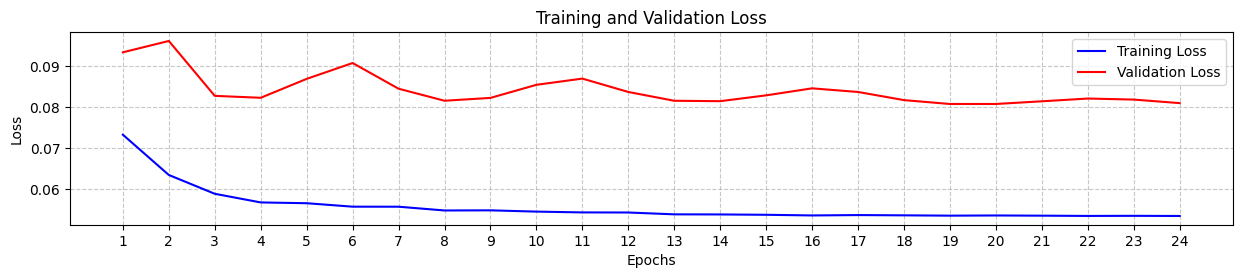

In [59]:
# Seguimiento del entrenamiento y overfitting
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 2.5))
forecaster.plot_history(ax=ax)

## se aprecia que apartir de la epoch 6 el modelo deja de aprender

In [60]:
predictions = forecaster.predict()

print(predictions.shape)
predictions.head()

(9, 1099)


,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,010facf4-08f0-4b25-9eef-2522a8caed4b_B1,015ad371-f82f-4eba-ab3a-dc4c77262d23_B2,015ad371-f82f-4eba-ab3a-dc4c77262d23_B3,016910ce-27cd-4536-9b14-96e9caec3f56_B3,01ceb2f7-f178-4a23-b470-20755a3be241_B3,03506bee-8edc-4c03-b10e-4126b943a339_B1,03506bee-8edc-4c03-b10e-4126b943a339_B3,03b56f4c-f2ec-4ee5-8341-87ef3e39a90e_B3,04587b04-b34d-477a-8c24-1edf1f9effc7_B3,047af93a-b988-4cfe-8af7-5d793960b295_B3,04f07f2c-ed89-4c69-9de3-e24f28032748_B1,04f07f2c-ed89-4c69-9de3-e24f28032748_B2,04f07f2c-ed89-4c69-9de3-e24f28032748_B3,0548991e-185f-497f-9c37-d7e9c51edff0_B1,0548991e-185f-497f-9c37-d7e9c51edff0_B2,0548991e-185f-497f-9c37-d7e9c51edff0_B3,0576299b-d2b9-4a95-9f65-aa74f303726a_B1,0576299b-d2b9-4a95-9f65-aa74f303726a_B2,0576299b-d2b9-4a95-9f65-aa74f303726a_B3,05d77e9c-c279-402d-b882-f2f533e0b221_B1,05d77e9c-c279-402d-b882-f2f533e0b221_B2,05d77e9c-c279-402d-b882-f2f533e0b221_B3,063a0fae-8732-42e9-ae25-aefcdffce44e_B1,063a0fae-8732-42e9-ae25-aefcdffce44e_B2,063a0fae-8732-42e9-ae25-aefcdffce44e_B3,06c3de3a-5134-4a31-8b48-9d7bd0370125_B2,06c3de3a-5134-4a31-8b48-9d7bd0370125_B3,06d507fe-e703-4a06-8efb-bd61a38990f3_B1,06d507fe-e703-4a06-8efb-bd61a38990f3_B3,07078fae-2d0b-4225-99aa-587b5920a2ee_B3,07c415af-fed1-4cc4-b702-7314e1eeba4c_B3,094ecf84-9014-4900-9c53-efc209159c40_B1,094ecf84-9014-4900-9c53-efc209159c40_B2,094ecf84-9014-4900-9c53-efc209159c40_B3,0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B1,0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B2,0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B3,0aa4d643-34b7-4973-85d0-b15efeff3e54_B1,0aa4d643-34b7-4973-85d0-b15efeff3e54_B2,0aa4d643-34b7-4973-85d0-b15efeff3e54_B3,0b0c7b9a-ec28-4971-9d11-435c2db92869_B3,0be705d4-b5df-47b9-9947-4f30ffb916ef_B1,0be705d4-b5df-47b9-9947-4f30ffb916ef_B2,0be705d4-b5df-47b9-9947-4f30ffb916ef_B3,0c511b76-393d-4970-85a0-db86ea2f16fe_B1,0c511b76-393d-4970-85a0-db86ea2f16fe_B3,0c72f97a-24c8-497c-b405-f4f79088b06d_B1,0c72f97a-24c8-497c-b405-f4f79088b06d_B2,0c72f97a-24c8-497c-b405-f4f79088b06d_B3,0cd34cc6-1752-4523-89a6-9852a560c41a_B1,0cd34cc6-1752-4523-89a6-9852a560c41a_B2,0cd34cc6-1752-4523-89a6-9852a560c41a_B3,0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B1,0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B2,0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B3,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B1,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B2,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B3,0d6f6c33-a832-4136-b73b-020d7a2f3550_B3,100c5a11-9a98-4ebb-865e-7be67d2661a4_B2,100c5a11-9a98-4ebb-865e-7be67d2661a4_B3,1099141d-d4f7-4987-9b5d-43241fe58d80_B1,1099141d-d4f7-4987-9b5d-43241fe58d80_B2,1099141d-d4f7-4987-9b5d-43241fe58d80_B3,11154147-50f4-4f1d-a6e2-77cc0e45d97b_B3,11844c48-064a-4e22-984f-09e58aaff9bc_B1,11844c48-064a-4e22-984f-09e58aaff9bc_B3,11c9d841-fac0-4175-af5d-6feef5bf3838_B1,11c9d841-fac0-4175-af5d-6feef5bf3838_B2,11c9d841-fac0-4175-af5d-6feef5bf3838_B3,124a644a-8dd6-447b-bf3a-265db14fd4e6_B3,1351c284-325a-413f-bf21-b0d5e33b0355_B1,1351c284-325a-413f-bf21-b0d5e33b0355_B2,1351c284-325a-413f-bf21-b0d5e33b0355_B3,1354527f-78a7-4686-abb7-12d7ce15f5c4_B1,1354527f-78a7-4686-abb7-12d7ce15f5c4_B3,137479a2-c876-42a1-83a0-6db651b73c09_B3,14b17489-499e-46e3-a12e-caf20f1c9bed_B3,16e161b8-a6e9-44eb-bb6e-deae61d53186_B1,16e161b8-a6e9-44eb-bb6e-deae61d53186_B2,16e161b8-a6e9-44eb-bb6e-deae61d53186_B3,17887e80-fa42-4286-9c8a-d6cff4da4a00_B1,17887e80-fa42-4286-9c8a-d6cff4da4a00_B2,17887e80-fa42-4286-9c8a-d6cff4da4a00_B3,1829fd45-0814-42cc-a186-cfb838b67167_B1,1829fd45-0814-42cc-a186-cfb838b67167_B3,19435f74-b180-4ef0-9abd-f9598d335034_B1,19435f74-b180-4ef0-9abd-f9598d335034_B3,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B1,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B2,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B3,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B1,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B2,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B3,1b4dec01-ac5c-48c2-a18e-7bdd868b33df_B3,1c9641b7-ba05-4b66-92f6-c04d046ab618_B1,1c9641b7-ba05-4b66-92f6-c04d046ab618_B2,1c9641b7-ba05-4b66-92f6-c04d046ab618_B3

In [61]:
# Backtesting con datos de test
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]), # Datos de entrenamiento + validación
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step - loss: 0.0497 - val_loss: 0.0794
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0494 - val_loss: 0.0789
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0494 - val_loss: 0.0786
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0492 - val_loss: 0.0781
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0488 - val_loss: 0.0775
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0485 - val_loss: 0.0771
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0484 - val_loss: 0.0766
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0482 - val_loss: 0.0761
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0479 - val_loss: 0.0760
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0477 - val_loss: 0.0760
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0477 - val_loss: 0.0759
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0476 - val_l

  0%|          | 0/2 [00:00<?, ?it/s]

tensorflow WARNING 5 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001598A9587C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


In [63]:
# es un error medianamente bajo

metrics.loc[0, 'mean_absolute_error'] 

0.25136106507852674

In [64]:
df_backtest_predictions=predictions.melt(ignore_index=False,var_name='series_id', value_name='value_pred').reset_index(names='date')
df_backtest_predictions.head()

,date,series_id,value_pred
0,2024-07-23,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1,0.160377
1,2024-07-24,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1,0.155714
2,2024-07-25,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1,0.157911
3,2024-07-26,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1,0.135381
4,2024-07-27,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1,0.123418


In [65]:
df_backtest_predictions_=df.merge(df_backtest_predictions,on=['series_id','date'])

df_backtest_predictions_['error']=df_backtest_predictions_['sales']-df_backtest_predictions_['value_pred']

## se observa que el modelo a diferencia del de ML es mas conservador, subestima el ingreso  
df_backtest_predictions_['error'].mean()

0.37859126635756796

In [66]:
## guardamos el modelo lstm 
import pickle

archivo_pickle = f'{models_dir}modelo_b_4_lstm.pkl'

# Guardar el objeto en un archivo pickle
with open(archivo_pickle, 'wb') as archivo:
    pickle.dump(forecaster, archivo)

## 5. Modelo base Final

In [29]:
## aca tomo el un criterio de que se quiere saber las ventas de los productos que se estaban vendiendo. tambien se podria tomar una ventana de las ultima semana de los productos vendidos y proyectar su ventas

## por lo tanto voy a filtar todos los productos que tuviern venta en el ultimo corte y proyectar su ventas 


df[df["date"]==df.date.max()].head()

,product_id,city,date,sales,day_of_week,sin_day_of_week,cos_day_of_week,weekend,series_id
67,03506bee-8edc-4c03-b10e-4126b943a339,B3,2024-08-07,1.0,2,0.974928,-0.222521,0,03506bee-8edc-4c03-b10e-4126b943a339_B3
65,04f07f2c-ed89-4c69-9de3-e24f28032748,B3,2024-08-07,4.0,2,0.974928,-0.222521,0,04f07f2c-ed89-4c69-9de3-e24f28032748_B3
64,04f07f2c-ed89-4c69-9de3-e24f28032748,B1,2024-08-07,3.0,2,0.974928,-0.222521,0,04f07f2c-ed89-4c69-9de3-e24f28032748_B1
57,04f07f2c-ed89-4c69-9de3-e24f28032748,B2,2024-08-07,1.0,2,0.974928,-0.222521,0,04f07f2c-ed89-4c69-9de3-e24f28032748_B2
67,0548991e-185f-497f-9c37-d7e9c51edff0,B3,2024-08-07,1.0,2,0.974928,-0.222521,0,0548991e-185f-497f-9c37-d7e9c51edff0_B3


In [30]:
df['series_id']=df['product_id'].astype(str).str.strip() +'_'+df['city'].astype(str).str.strip()

In [31]:
## este seria una "ETL" simplificado  

fecha_observacion = pd.to_datetime(df.date.max())  # Fecha de observación
fecha_observacion_lags=fecha_observacion-pd.Timedelta(days=7)


series_ids = df[df["date"]==fecha_observacion]['series_id'].to_list()

## la base de los ultimos lags
df_last_window=df[(df["series_id"].isin(series_ids))&
   df["date"].between(fecha_observacion_lags,fecha_observacion)][['series_id','date','sales']]


In [32]:
## ids entrenado

ids=forecaster.last_window.columns.to_list()
len(ids)

1099

In [33]:
## ids que no estan en la ultimo analisis
dif_list=list(set(ids)-set(series_ids))
len(dif_list)

728

In [34]:
df_sin_ventas=pd.DataFrame(data={'series_id':dif_list,
                   'date':fecha_observacion,
                   'sales':0
                   })

In [35]:
df_last_window_=pd.concat([df_last_window,df_sin_ventas])

In [36]:
selected_items = df_last_window_.series_id.unique()
df_last_window_pred = df_last_window_[['series_id','date','sales']]

df_last_window_pred['date'] = pd.to_datetime(df_last_window_pred['date'], format='%Y-%m-%d')
df_last_window_pred = pd.pivot_table(
           data    = df_last_window_pred,
           values  = 'sales',
           index   = 'date',
           columns = 'series_id'
       )
df_last_window_pred.columns.name = None
df_last_window_pred = df_last_window_pred.asfreq('1D')
df_last_window_pred = df_last_window_pred.sort_index()
df_last_window_pred.fillna(0,inplace=True)
df_last_window_pred.head(4)

,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,010facf4-08f0-4b25-9eef-2522a8caed4b_B1,015ad371-f82f-4eba-ab3a-dc4c77262d23_B2,015ad371-f82f-4eba-ab3a-dc4c77262d23_B3,016910ce-27cd-4536-9b14-96e9caec3f56_B3,01ceb2f7-f178-4a23-b470-20755a3be241_B3,03506bee-8edc-4c03-b10e-4126b943a339_B1,03506bee-8edc-4c03-b10e-4126b943a339_B3,03b56f4c-f2ec-4ee5-8341-87ef3e39a90e_B3,04587b04-b34d-477a-8c24-1edf1f9effc7_B3,047af93a-b988-4cfe-8af7-5d793960b295_B3,04f07f2c-ed89-4c69-9de3-e24f28032748_B1,04f07f2c-ed89-4c69-9de3-e24f28032748_B2,04f07f2c-ed89-4c69-9de3-e24f28032748_B3,0548991e-185f-497f-9c37-d7e9c51edff0_B1,0548991e-185f-497f-9c37-d7e9c51edff0_B2,0548991e-185f-497f-9c37-d7e9c51edff0_B3,0576299b-d2b9-4a95-9f65-aa74f303726a_B1,0576299b-d2b9-4a95-9f65-aa74f303726a_B2,0576299b-d2b9-4a95-9f65-aa74f303726a_B3,05d77e9c-c279-402d-b882-f2f533e0b221_B1,05d77e9c-c279-402d-b882-f2f533e0b221_B2,05d77e9c-c279-402d-b882-f2f533e0b221_B3,063a0fae-8732-42e9-ae25-aefcdffce44e_B1,063a0fae-8732-42e9-ae25-aefcdffce44e_B2,063a0fae-8732-42e9-ae25-aefcdffce44e_B3,06c3de3a-5134-4a31-8b48-9d7bd0370125_B2,06c3de3a-5134-4a31-8b48-9d7bd0370125_B3,06d507fe-e703-4a06-8efb-bd61a38990f3_B1,06d507fe-e703-4a06-8efb-bd61a38990f3_B3,07078fae-2d0b-4225-99aa-587b5920a2ee_B3,07c415af-fed1-4cc4-b702-7314e1eeba4c_B3,094ecf84-9014-4900-9c53-efc209159c40_B1,094ecf84-9014-4900-9c53-efc209159c40_B2,094ecf84-9014-4900-9c53-efc209159c40_B3,0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B1,0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B2,0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B3,0aa4d643-34b7-4973-85d0-b15efeff3e54_B1,0aa4d643-34b7-4973-85d0-b15efeff3e54_B2,0aa4d643-34b7-4973-85d0-b15efeff3e54_B3,0b0c7b9a-ec28-4971-9d11-435c2db92869_B3,0be705d4-b5df-47b9-9947-4f30ffb916ef_B1,0be705d4-b5df-47b9-9947-4f30ffb916ef_B2,0be705d4-b5df-47b9-9947-4f30ffb916ef_B3,0c511b76-393d-4970-85a0-db86ea2f16fe_B1,0c511b76-393d-4970-85a0-db86ea2f16fe_B3,0c72f97a-24c8-497c-b405-f4f79088b06d_B1,0c72f97a-24c8-497c-b405-f4f79088b06d_B2,0c72f97a-24c8-497c-b405-f4f79088b06d_B3,0cd34cc6-1752-4523-89a6-9852a560c41a_B1,0cd34cc6-1752-4523-89a6-9852a560c41a_B2,0cd34cc6-1752-4523-89a6-9852a560c41a_B3,0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B1,0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B2,0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B3,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B1,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B2,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B3,0d6f6c33-a832-4136-b73b-020d7a2f3550_B3,100c5a11-9a98-4ebb-865e-7be67d2661a4_B2,100c5a11-9a98-4ebb-865e-7be67d2661a4_B3,1099141d-d4f7-4987-9b5d-43241fe58d80_B1,1099141d-d4f7-4987-9b5d-43241fe58d80_B2,1099141d-d4f7-4987-9b5d-43241fe58d80_B3,11154147-50f4-4f1d-a6e2-77cc0e45d97b_B3,11844c48-064a-4e22-984f-09e58aaff9bc_B1,11844c48-064a-4e22-984f-09e58aaff9bc_B3,11c9d841-fac0-4175-af5d-6feef5bf3838_B1,11c9d841-fac0-4175-af5d-6feef5bf3838_B2,11c9d841-fac0-4175-af5d-6feef5bf3838_B3,124a644a-8dd6-447b-bf3a-265db14fd4e6_B3,1351c284-325a-413f-bf21-b0d5e33b0355_B1,1351c284-325a-413f-bf21-b0d5e33b0355_B2,1351c284-325a-413f-bf21-b0d5e33b0355_B3,1354527f-78a7-4686-abb7-12d7ce15f5c4_B1,1354527f-78a7-4686-abb7-12d7ce15f5c4_B3,137479a2-c876-42a1-83a0-6db651b73c09_B3,14b17489-499e-46e3-a12e-caf20f1c9bed_B3,16e161b8-a6e9-44eb-bb6e-deae61d53186_B1,16e161b8-a6e9-44eb-bb6e-deae61d53186_B2,16e161b8-a6e9-44eb-bb6e-deae61d53186_B3,17887e80-fa42-4286-9c8a-d6cff4da4a00_B1,17887e80-fa42-4286-9c8a-d6cff4da4a00_B2,17887e80-fa42-4286-9c8a-d6cff4da4a00_B3,1829fd45-0814-42cc-a186-cfb838b67167_B1,1829fd45-0814-42cc-a186-cfb838b67167_B3,19435f74-b180-4ef0-9abd-f9598d335034_B1,19435f74-b180-4ef0-9abd-f9598d335034_B3,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B1,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B2,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B3,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B1,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B2,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B3,1b4dec01-ac5c-48c2-a18e-7bdd868b33df_B3,1c9641b7-ba05-4b66-92f6-c04d046ab618_B1,1c9641b7-ba05-4b66-92f6-c04d046ab618_B2,1c9641b7-ba05-4b66-92f6-c04d046ab618_B3

In [37]:
## Subimos el modelo entrenado

import pickle
archivo_pickle = f'{models_dir}modelo_b_4_lstm.pkl'

# Cargar el objeto desde el archivo pickle
with open(archivo_pickle, 'rb') as archivo:
    forecaster = pickle.load(archivo)

In [38]:
predicciones_pred = forecaster.predict(last_window=df_last_window_pred)
predicciones_pred.head()

,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,010facf4-08f0-4b25-9eef-2522a8caed4b_B1,015ad371-f82f-4eba-ab3a-dc4c77262d23_B2,015ad371-f82f-4eba-ab3a-dc4c77262d23_B3,016910ce-27cd-4536-9b14-96e9caec3f56_B3,01ceb2f7-f178-4a23-b470-20755a3be241_B3,03506bee-8edc-4c03-b10e-4126b943a339_B1,03506bee-8edc-4c03-b10e-4126b943a339_B3,03b56f4c-f2ec-4ee5-8341-87ef3e39a90e_B3,04587b04-b34d-477a-8c24-1edf1f9effc7_B3,047af93a-b988-4cfe-8af7-5d793960b295_B3,04f07f2c-ed89-4c69-9de3-e24f28032748_B1,04f07f2c-ed89-4c69-9de3-e24f28032748_B2,04f07f2c-ed89-4c69-9de3-e24f28032748_B3,0548991e-185f-497f-9c37-d7e9c51edff0_B1,0548991e-185f-497f-9c37-d7e9c51edff0_B2,0548991e-185f-497f-9c37-d7e9c51edff0_B3,0576299b-d2b9-4a95-9f65-aa74f303726a_B1,0576299b-d2b9-4a95-9f65-aa74f303726a_B2,0576299b-d2b9-4a95-9f65-aa74f303726a_B3,05d77e9c-c279-402d-b882-f2f533e0b221_B1,05d77e9c-c279-402d-b882-f2f533e0b221_B2,05d77e9c-c279-402d-b882-f2f533e0b221_B3,063a0fae-8732-42e9-ae25-aefcdffce44e_B1,063a0fae-8732-42e9-ae25-aefcdffce44e_B2,063a0fae-8732-42e9-ae25-aefcdffce44e_B3,06c3de3a-5134-4a31-8b48-9d7bd0370125_B2,06c3de3a-5134-4a31-8b48-9d7bd0370125_B3,06d507fe-e703-4a06-8efb-bd61a38990f3_B1,06d507fe-e703-4a06-8efb-bd61a38990f3_B3,07078fae-2d0b-4225-99aa-587b5920a2ee_B3,07c415af-fed1-4cc4-b702-7314e1eeba4c_B3,094ecf84-9014-4900-9c53-efc209159c40_B1,094ecf84-9014-4900-9c53-efc209159c40_B2,094ecf84-9014-4900-9c53-efc209159c40_B3,0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B1,0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B2,0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B3,0aa4d643-34b7-4973-85d0-b15efeff3e54_B1,0aa4d643-34b7-4973-85d0-b15efeff3e54_B2,0aa4d643-34b7-4973-85d0-b15efeff3e54_B3,0b0c7b9a-ec28-4971-9d11-435c2db92869_B3,0be705d4-b5df-47b9-9947-4f30ffb916ef_B1,0be705d4-b5df-47b9-9947-4f30ffb916ef_B2,0be705d4-b5df-47b9-9947-4f30ffb916ef_B3,0c511b76-393d-4970-85a0-db86ea2f16fe_B1,0c511b76-393d-4970-85a0-db86ea2f16fe_B3,0c72f97a-24c8-497c-b405-f4f79088b06d_B1,0c72f97a-24c8-497c-b405-f4f79088b06d_B2,0c72f97a-24c8-497c-b405-f4f79088b06d_B3,0cd34cc6-1752-4523-89a6-9852a560c41a_B1,0cd34cc6-1752-4523-89a6-9852a560c41a_B2,0cd34cc6-1752-4523-89a6-9852a560c41a_B3,0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B1,0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B2,0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B3,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B1,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B2,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B3,0d6f6c33-a832-4136-b73b-020d7a2f3550_B3,100c5a11-9a98-4ebb-865e-7be67d2661a4_B2,100c5a11-9a98-4ebb-865e-7be67d2661a4_B3,1099141d-d4f7-4987-9b5d-43241fe58d80_B1,1099141d-d4f7-4987-9b5d-43241fe58d80_B2,1099141d-d4f7-4987-9b5d-43241fe58d80_B3,11154147-50f4-4f1d-a6e2-77cc0e45d97b_B3,11844c48-064a-4e22-984f-09e58aaff9bc_B1,11844c48-064a-4e22-984f-09e58aaff9bc_B3,11c9d841-fac0-4175-af5d-6feef5bf3838_B1,11c9d841-fac0-4175-af5d-6feef5bf3838_B2,11c9d841-fac0-4175-af5d-6feef5bf3838_B3,124a644a-8dd6-447b-bf3a-265db14fd4e6_B3,1351c284-325a-413f-bf21-b0d5e33b0355_B1,1351c284-325a-413f-bf21-b0d5e33b0355_B2,1351c284-325a-413f-bf21-b0d5e33b0355_B3,1354527f-78a7-4686-abb7-12d7ce15f5c4_B1,1354527f-78a7-4686-abb7-12d7ce15f5c4_B3,137479a2-c876-42a1-83a0-6db651b73c09_B3,14b17489-499e-46e3-a12e-caf20f1c9bed_B3,16e161b8-a6e9-44eb-bb6e-deae61d53186_B1,16e161b8-a6e9-44eb-bb6e-deae61d53186_B2,16e161b8-a6e9-44eb-bb6e-deae61d53186_B3,17887e80-fa42-4286-9c8a-d6cff4da4a00_B1,17887e80-fa42-4286-9c8a-d6cff4da4a00_B2,17887e80-fa42-4286-9c8a-d6cff4da4a00_B3,1829fd45-0814-42cc-a186-cfb838b67167_B1,1829fd45-0814-42cc-a186-cfb838b67167_B3,19435f74-b180-4ef0-9abd-f9598d335034_B1,19435f74-b180-4ef0-9abd-f9598d335034_B3,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B1,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B2,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B3,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B1,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B2,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B3,1b4dec01-ac5c-48c2-a18e-7bdd868b33df_B3,1c9641b7-ba05-4b66-92f6-c04d046ab618_B1,1c9641b7-ba05-4b66-92f6-c04d046ab618_B2,1c9641b7-ba05-4b66-92f6-c04d046ab618_B3

In [39]:
predicciones_pred_=predicciones_pred.melt(ignore_index=False,var_name='series_id', value_name='sales').reset_index(names='timestamp')

predicciones_pred_.head(2)

,timestamp,series_id,sales
0,2024-08-08,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1,0.080565
1,2024-08-09,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1,-0.219603


In [40]:
df_product=df[df["date"]==df.date.max()][['series_id','product_id','city']].drop_duplicates()
df_product.shape

(371, 3)

In [41]:
df_pred=df_product.merge(predicciones_pred_,on='series_id')
df_pred.shape

(3339, 5)

In [42]:
fecha_observacion_1=fecha_observacion+pd.Timedelta(days=1)
fecha_observacion_2=fecha_observacion+pd.Timedelta(days=2)
fecha_observacion_3=fecha_observacion+pd.Timedelta(days=3)
fecha_observacion_3+pd.Timedelta(days=6)

Timestamp('2024-08-16 00:00:00')

In [43]:
## el error del modelo de backtsting es postivo alrededor de 0.24 , para este caso vamos a redondear primero el valor y luego pasar a int

group=['product_id','city']

df_pred['sales']=round(df_pred['sales'],0).astype(int)
df_1=df_pred[df_pred["timestamp"].between(fecha_observacion_1,fecha_observacion_1+pd.Timedelta(days=6))].groupby(group).agg(sales=('sales','sum')).reset_index()
df_1['date']=fecha_observacion_1
df_2=df_pred[df_pred["timestamp"].between(fecha_observacion_2,fecha_observacion_2+pd.Timedelta(days=6))].groupby(group).agg(sales=('sales','sum')).reset_index()
df_2['date']=fecha_observacion_2
df_3=df_pred[df_pred["timestamp"].between(fecha_observacion_3,fecha_observacion_3+pd.Timedelta(days=6))].groupby(group).agg(sales=('sales','sum')).reset_index()
df_3['date']=fecha_observacion_3


submission=pd.concat([df_1,df_2,df_3])
submission.head()

,product_id,city,sales,date
0,03506bee-8edc-4c03-b10e-4126b943a339,B3,5,2024-08-08
1,04f07f2c-ed89-4c69-9de3-e24f28032748,B1,0,2024-08-08
2,04f07f2c-ed89-4c69-9de3-e24f28032748,B2,0,2024-08-08
3,04f07f2c-ed89-4c69-9de3-e24f28032748,B3,2,2024-08-08
4,0548991e-185f-497f-9c37-d7e9c51edff0,B1,3,2024-08-08


In [44]:
## guardar base

submission_v00 = f'{data_dir}submission_v01.csv'

submission.to_csv(submission_v00)

## 6. Conclusiones 

El modelo ha mostrado un rendimiento notable. En comparación con el modelo basado en machine learning, que obtuvo un `mean_absolute_error` de 1.19 en el backtesting, este nuevo modelo logró reducir el error a 0.251, lo que representa una mejora de casi cuatro veces.

A pesar de que algunos parámetros fueron dejados con valores predeterminados y no se utilizaron variables exógenas, los resultados obtenidos son muy prometedores. Esto sugiere que, con un mayor conocimiento y optimización, se podría alcanzar un rendimiento aún mejor. De hecho, según lo que he investigado, esta herramienta es reconocida como una de las mejores en el mercado para este tipo de tareas.
